In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from scipy import stats
import powerlaw

C:\Users\ldonaire\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import pickle

def write_pkl(var,name_file):
    with open(f'variables_final\\{name_file}.pkl','wb') as arquivo:
        pickle.dump(var,arquivo)

def read_pkl(name_file):
    with open(f'variables_final\\{name_file}.pkl','rb') as arquivo:
        return pickle.load(arquivo)
    
def get_code_read_pkl(code_write_pkl):
    S = code_write_pkl.split("write_pkl(")[1]
    S = S.split("'")
    return S[0][:-1] + ' = read_pkl("' + S[1] + '")'

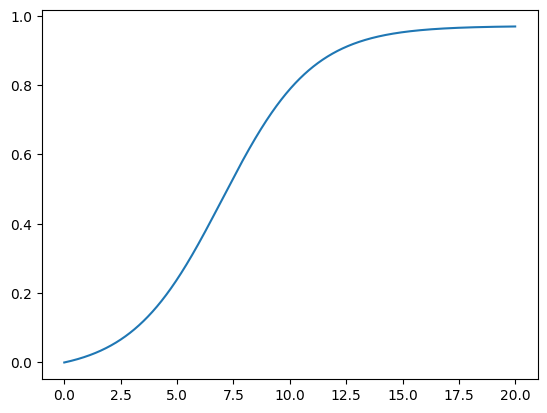

In [3]:
phi_min = 0.0 
phi_max = 1 
beta = 0.5
v_half = 7

def phi0(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi_min + phi_max/(1+np.exp(-beta*(V-v_half)))

def phi(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi0(V, phi_min, phi_max, beta, v_half) - phi0(0, phi_min, phi_max, beta, v_half)

x = np.arange(0,20,0.01)
y = phi(x)
plt.plot(x,y)

In [4]:
def uniform_W(k,N):
    W = k * (np.ones((N,N)) - np.eye(N))
    return W

def erdos_reny_W(k,N,p):
    W = k * np.random.binomial(1, p, size=(N, N))
    W = W - W*np.eye(N)
    return W

In [5]:
t_ref       = 0.0   # refractory period in (ms)
V_reset     = 0.0   # reset membrane potential in (mV)
def run_simulation_full(W, reset_V=True, t_sim=100, alpha=1, phi=phi, Vmax0=15, prints=False, Vmin0=0, V0=[], seed=None):
    if not pd.isnull(seed):
        np.random.seed(seed)

    #initial conditions
    phis = []
    times = []
    Vs = []

    N = len(W)
    V = np.random.uniform(Vmin0, Vmax0, size=N) 

    phi_u = np.zeros(N)    #array to store phi values
    last_spike = np.zeros(N)   # array to store last time of spike for each neuron

    # arrays to store spikes
    spk_t = [] # tempo do spike
    possible_spike_t = [] # tempo do possivel spike
    spk_id = [] # id do neuronio (0 a N-1) que teve o spike
    
    trun = 0.0 # tempo de simulacao

    times.append(trun)
    phis.append(phi_u)
    Vs.append(V)

    while (trun < t_sim):
        ALL=all(V<0.001) # sistema morre quando todos potenciais ficam abaixo de um limiar arbitrario. nesse caso, 0.001
        if ALL: 
            return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)
        
        # compute phi(T-dt)
        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break

        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        
        V_old = V
        V = (V)*np.exp(-alpha*dt)
        #compute V(T)
        # phi em T
        phi_u = phi(V) 

        # joga uniforme
        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        trun += dt

        times.append(trun)
        phis.append(phi_u)
        Vs.append(V)

        possible_spike_t.append(trun)

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele

            # checking refractory period
            if last_spike[neuron_id]==0 or (trun-last_spike[neuron_id])>=t_ref:

                # updating of postsynaptic currents:
                V = V+W[neuron_id]
                last_spike[neuron_id] = trun
                # recording spike time and neuron index:
                spk_t.append(trun)
                spk_id.append(neuron_id)
                if reset_V:
                    V[neuron_id] = V_reset # Zera potencial

    return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)




def run_simulation(W, reset_V=True, t_sim=100, alpha=1, phi=phi, Vmax0=15, prints=False, Vmin0=0, V0=[], seed=None):
    if not pd.isnull(seed):
        np.random.seed(seed)

    N = len(W)
    V = np.random.uniform(Vmin0, Vmax0, size=N) 
    phi_u = np.zeros(N)    #array to store phi values
    last_spike = np.zeros(N)   # array to store last time of spike for each neuron
    trun = 0.0 # tempo de simulacao
    nspikes = 0
    while (trun < t_sim):
        ALL=all(V<0.001) # sistema morre quando todos potenciais ficam abaixo de um limiar arbitrario. nesse caso, 0.001
        if ALL: 
            return nspikes, trun

        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break
        
        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        V = (V)*np.exp(-alpha*dt)
        phi_u = phi(V) 
        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        trun += dt

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele
            V = V+W[neuron_id]
            last_spike[neuron_id] = trun
            nspikes +=1
            if reset_V:
                V[neuron_id] = V_reset # Zera potencial

    return nspikes, trun

In [6]:
def fit_exp(dados):
    loc, LambdaInv = stats.expon.fit(dados,floc=0)
    return 1/LambdaInv
def test_exp(dados):
    Lambda = fit_exp(dados)
    statistic, p_value = stats.kstest(dados, 'expon', args=(0, 1/Lambda))
    return p_value


def fit_norm(dados):
    return stats.norm.fit(dados)
def test_norm(dados):
    mean, std = fit_norm(dados)
    statistic, p_value = stats.kstest(dados, 'norm', args=(mean, std))
    return p_value


def fit_lognorm(dados):
    return stats.lognorm.fit(dados, floc=0)
def test_lognorm(dados):
    shape, loc, scale = fit_lognorm(dados)
    statistic, p_value = stats.kstest(dados, 'lognorm', args=(shape, loc, scale))
    return p_value


In [7]:
def fit_powerlaw(dados, discreto=False,xmin=None):
    dados = [item for item in dados if item>0]
    if pd.isnull(xmin):
        xmin = min(dados)
        # print('xmin min dados',xmin)
    fit = powerlaw.Fit(dados, xmin=xmin, discrete=discreto)
    return fit
def test_powerlaw(dados, discreto=False,xmin=None):
    fit = fit_powerlaw(dados, discreto, xmin)
    empirical_cdf = fit.cdf()
    theoretical_cdf = fit.power_law.cdf()
    ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
    return p_value




def fit_powerlaw_fitxmin(dados, discreto=False):
    dados = [item for item in dados if item>0]
    dados = sorted(dados)
    parameter_range = {'xmin': [None, dados[len(dados)//5] ]}
    fit = powerlaw.Fit(dados,discrete=discreto, parameter_range=parameter_range)
    return fit

def test_powerlaw_fitxmin(dados, discreto=False):
    fit = fit_powerlaw_fitxmin(dados, discreto)
    empirical_cdf = fit.cdf()
    theoretical_cdf = fit.power_law.cdf()
    ks_stat, p_value = stats.ks_2samp(empirical_cdf[1], theoretical_cdf)
    return p_value

In [8]:
def plot_powerlaw(dados, discreto=False, xmin=None):
    fit = fit_powerlaw(dados, discreto, xmin)
    fig2 = fit.plot_pdf(color='b', linewidth=2)
    fig2 = fit.plot_cdf(color='r', linewidth=2)
    fig2 = fit.plot_ccdf(color='g', linewidth=2)
    fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
    fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig2)
    fit.power_law.plot_ccdf(color='g', linestyle='--', ax=fig2)
    plt.title(f'xmin = {fit.xmin}, alpha = {fit.alpha}')
    plt.show()

In [9]:
np.random.seed(10)
W_U30 = uniform_W(1, 30)

W_U100 = uniform_W(1, 100)
W_ER100 = erdos_reny_W(1,100,0.7)

W_U1000 = uniform_W(1, 1000)
W_ER1000 = erdos_reny_W(1,1000,0.7)

In [10]:
def run_hk(W, alpha, n_simulations=300):
    times_death = []
    num_spikes = []
    for i in range(n_simulations):
        print(i, pd.Timestamp.now())
        # spk_t, spk_id, phis, times, Vs, trun, possible_spike_t = run_simulation(W, False, np.inf, alpha)
        nspikes, trun = run_simulation(W, False, np.inf, alpha)
        times_death.append(trun)
        num_spikes.append(nspikes)
    return times_death, num_spikes

def find_alpha_critical_hk(W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    results = {}
    for i in range(max_tests):
        durations,sizes = run_hk(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'Hawkes | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    return alpha, durations, sizes, results

def find_alpha_critical_hk_append(results, W, string_W, alpha0, step, max_tests=20, plot=True):
    alpha = alpha0
    # results = {}
    for i in range(max_tests):
        print()
        print(f'alpha = {alpha}')
        if alpha in results.keys():
            print(alpha, 'in dicio')
            alpha = np.round(alpha-step,2)
            continue
        durations,sizes = run_hk(W, alpha, 300)
        results[alpha] = [durations,sizes]
        if plot:
            plt.hist(np.array(durations)/np.mean(durations), bins=[item/5 for item in range(15*10)], density=True)
            plt.title(f'Hawkes | {string_W} | alpha={np.round(alpha,2)} | pvalue={np.round(test_exp(durations),4)}')
            plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
            plt.show()
        if test_exp(durations) > 0.05:
            print('critical alpha')
            print(alpha)
            return alpha, durations, sizes, results
        alpha = np.round(alpha-step,2)
    print('No critical alpha found')
    results = dict(sorted(results.items(),reverse=True))
    return alpha, durations, sizes, results


        

In [11]:
[times_death, num_spikes] = read_pkl('alpha_critical\\HK_U1000_alpha43')

In [14]:
len(times_death)

66

In [ ]:
# times_death = []
# num_spikes = []
for i in range(300-len(times_death)):
    print(i, pd.Timestamp.now())
    nspikes, trun = run_simulation(W_U1000, False, np.inf, 43)
    times_death.append(trun)
    num_spikes.append(nspikes)

In [15]:
write_pkl([times_death, num_spikes],'alpha_critical\\HK_U1000_alpha43')